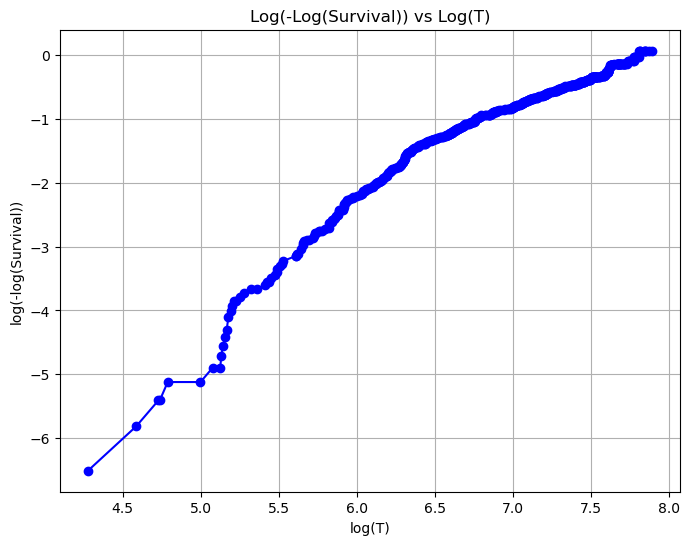

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('data/Recurrence free survival in breast cancer patients.csv')  # Replace with your file path

# Sort data by time
time_events = data[['time', 'status']].sort_values(by='time')
unique_times = time_events['time'].unique()

# Initialize counts
n_at_risk = len(time_events)
survival_prob = 1.0
survival_function = []

# Calculate the survival function
for t in unique_times:
    n_events = time_events[(time_events['time'] == t) & (time_events['status'] == 1)].shape[0]
    survival_prob *= (1 - n_events / n_at_risk)
    n_at_risk -= time_events[time_events['time'] == t].shape[0]
    survival_function.append((t, survival_prob))

# Convert survival function into DataFrame
survival_df = pd.DataFrame(survival_function, columns=['time', 'survival'])

# Filter out survival probabilities that are exactly 0 or 1
survival_df = survival_df[(survival_df['survival'] > 0) & (survival_df['survival'] < 1)]

# Calculate log(-log(survival)) and log(time)
survival_df['log_time'] = np.log(survival_df['time'])
survival_df['log_minus_log_survival'] = np.log(-np.log(survival_df['survival']))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(survival_df['log_time'], survival_df['log_minus_log_survival'], marker='o', linestyle='-', color='b')
plt.xlabel('log(T)')
plt.ylabel('log(-log(Survival))')
plt.title('Log(-Log(Survival)) vs Log(T)')
plt.grid(True)
plt.show()


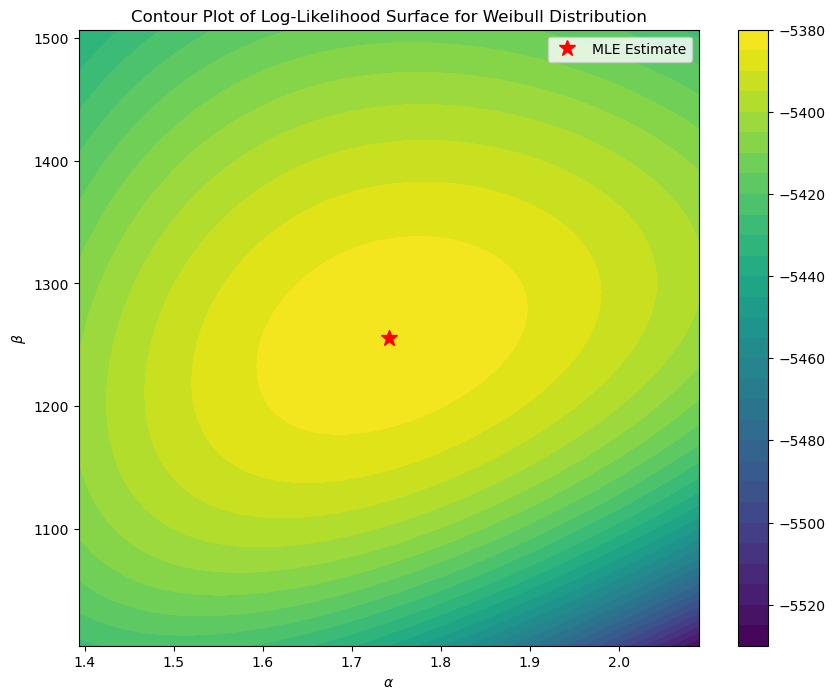

Estimated alpha: 1.7415449606291795
Estimated beta: 1255.7246574147048


In [16]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('data/Recurrence free survival in breast cancer patients.csv')  # Replace with your file path

# Extract survival times
survival_times = data['time'].values

# Step 1: Initial estimates based on quantiles
# Estimate of beta
beta_initial = np.quantile(survival_times, 1 - np.exp(-1))

# Estimate of alpha
median_y = np.median(survival_times)
alpha_initial = np.log(np.log(2)) / np.log(median_y / beta_initial)

# Define the log-likelihood function for the Weibull distribution
def weibull_log_likelihood(params, times):
    alpha, beta = params
    n = len(times)
    term1 = n * np.log(alpha) - n * alpha * np.log(beta)
    term2 = (alpha - 1) * np.sum(np.log(times))
    term3 = -np.sum((times / beta) ** alpha)
    return -(term1 + term2 + term3)

# Step 2: Maximize the log-likelihood function to find the best alpha and beta
initial_params = [alpha_initial, beta_initial]
result = minimize(weibull_log_likelihood, initial_params, args=(survival_times,),
                  method='L-BFGS-B', bounds=[(0.01, None), (0.01, None)])

# Extract optimized alpha and beta values
alpha_mle, beta_mle = result.x

# Step 3: Generate a grid of alpha and beta values around the MLE estimates for contour plot
alpha_range = np.linspace(alpha_mle * 0.8, alpha_mle * 1.2, 100)
beta_range = np.linspace(beta_mle * 0.8, beta_mle * 1.2, 100)
alpha_grid, beta_grid = np.meshgrid(alpha_range, beta_range)

# Calculate log-likelihood values for each pair in the grid
log_likelihood_values = np.zeros_like(alpha_grid)

for i in range(alpha_grid.shape[0]):
    for j in range(alpha_grid.shape[1]):
        log_likelihood_values[i, j] = -weibull_log_likelihood(
            [alpha_grid[i, j], beta_grid[i, j]], survival_times
        )

# Step 4: Plot the contour map
plt.figure(figsize=(10, 8))
contour = plt.contourf(alpha_grid, beta_grid, log_likelihood_values, levels=30, cmap='viridis')
plt.colorbar(contour)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.title('Contour Plot of Log-Likelihood Surface for Weibull Distribution')
plt.plot(alpha_mle, beta_mle, 'r*', markersize=12, label='MLE Estimate')
plt.legend()
plt.show()

print(f"Estimated alpha: {alpha_mle}")
print(f"Estimated beta: {beta_mle}")

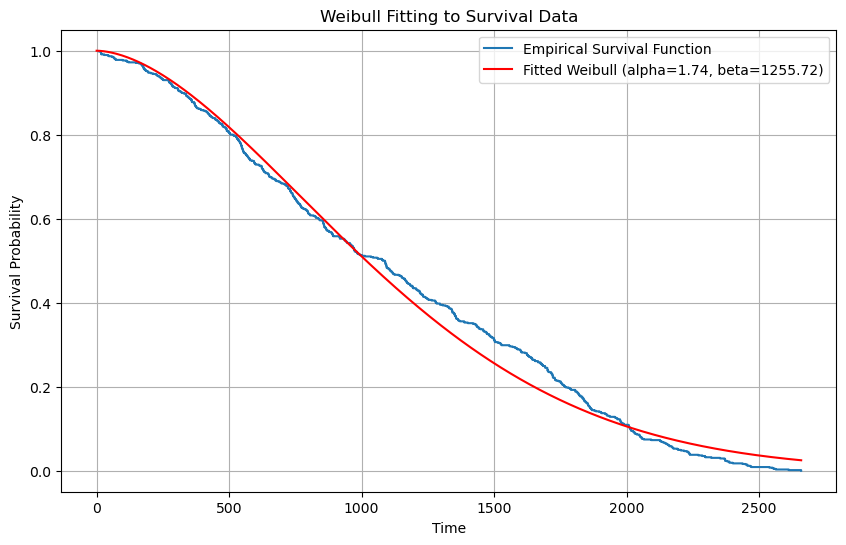

In [17]:
# Step 2: Fit Weibull distribution to data with estimated alpha and beta
# Define the Weibull CDF for fitting
def weibull_cdf(t, alpha, beta):
    return 1 - np.exp(-(t / beta) ** alpha)

# Generate data points for plotting the fitted Weibull survival curve
time_range = np.linspace(0, max(survival_times), 500)
survival_curve = 1 - weibull_cdf(time_range, alpha_mle, beta_mle)

# Step 3: Plot the empirical survival function and the fitted Weibull survival curve
plt.figure(figsize=(10, 6))
plt.step(np.sort(survival_times), 1 - np.arange(1, len(survival_times) + 1) / len(survival_times),
         where='post', label='Empirical Survival Function')
plt.plot(time_range, survival_curve, 'r-', label=f'Fitted Weibull (alpha={alpha_mle:.2f}, beta={beta_mle:.2f})')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Weibull Fitting to Survival Data')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
import numpy as np

def concordance_index(event_times, predicted_times, event_observed):
    """
    Calculate the concordance index (C-index) for survival predictions.

    Parameters:
    - event_times: array-like, actual observed event times.
    - predicted_times: array-like, predicted event times (or survival probabilities).
    - event_observed: array-like, indicator of event occurrence (1 if event occurred, 0 if censored).

    Returns:
    - c_index: float, the concordance index.
    """
    n = len(event_times)
    assert len(predicted_times) == n and len(event_observed) == n, "Input arrays must have the same length"

    # Initialize counts for concordant and permissible pairs
    concordant = 0
    permissible = 0

    # Compare each pair of event times
    for i in range(n):
        for j in range(i + 1, n):
            # Both events must be uncensored or one censored with a known survival ordering
            if event_observed[i] == 1 or event_observed[j] == 1:
                permissible += 1
                # Check if the predicted survival matches the actual ordering
                if (event_times[i] < event_times[j] and predicted_times[i] < predicted_times[j]) or \
                   (event_times[i] > event_times[j] and predicted_times[i] > predicted_times[j]):
                    concordant += 1
                elif predicted_times[i] == predicted_times[j]:  # Tie in predictions
                    concordant += 0.5

    # Compute the concordance index
    c_index = concordant / permissible if permissible > 0 else 0
    return c_index

# Example usage:
# Assume 'survival_times' contains observed event times and 'predicted_times' is calculated from the Weibull model
# event_observed indicates if the event was observed (1) or censored (0)

# survival_times = data['time'].values  # Observed event times
# event_observed = data['status'].values  # Event observed or censored
# predicted_times = beta_mle * (-np.log(1 - weibull_cdf(survival_times, alpha_mle, beta_mle))) ** (1 / alpha_mle)

# c_index = concordance_index(survival_times, predicted_times, event_observed)
# print(f"Concordance Index: {c_index}")


In [19]:
survival_times = data['time'].values  # Observed event times
event_observed = data['status'].values  # Event observed or censored
predicted_times = beta_mle * (-np.log(1 - weibull_cdf(survival_times, alpha_mle, beta_mle))) ** (1 / alpha_mle)

c_index = concordance_index(survival_times, predicted_times, event_observed)
print(f"Concordance Index: {c_index}")

Concordance Index: 0.9997691309339589
